# Offline Phase

This notebook implements the offline phase of the following algorithms:

- Proper Orthogonal Decomposition (POD)

In particular, the basis functions (named *modes*) are generated through the POD procedure, the maps between parameters and reduced coefficients are created and, in the end, the modes are plotted using `pyvista`.

In [1]:
import gmsh
import os
from IPython.display import clear_output
import numpy as np

from dolfinx.fem import FunctionSpace
from pyforce.offline.pod import POD
import ufl

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

from mpi4py import MPI
from dolfinx.io import gmshio

from pyforce.tools.functions_list import FunctionsList, train_test_split
from pyforce.tools.write_read import StoreFunctionsList as store, ImportH5


path='./Offline_results'
if not os.path.exists(path):
    os.makedirs(path)

The geometry is imported from "cyk_dfg2D.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [2]:
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh_factor = .35

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('cyl_dfg2D.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)
gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)
gdim = 2

# Linear Finite Element
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

clear_output()

# Import into dolfinx
model_rank = 0
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim = gdim )

domain.topology.create_connectivity(gdim, gdim)
domain.topology.create_connectivity(gdim-1, gdim)

# Finalize the gmsh module
gmsh.finalize()

## Importing Snapshots

The snapshots are loaded and stored into suitable data structures.

In [3]:
# Defining the functional space
fun_spaces = [FunctionSpace(domain, ("Lagrange", 1)),
              FunctionSpace(domain, ufl.VectorElement("Lagrange", domain.ufl_cell(), 1))]

# Define the variables to load
var_names = [
             'p',
             'u'
             ]

tex_var_names = [
                 r'p',
                 r'\mathbf{u}'
                 ]

stored_var_names = [
                    'p',
                    'U'
                    ]


# Snapshot path
path_FOM = './Snapshots/'

################ Importing Snapshots ########################
train_snaps = list()
# test_snaps  = list()

train_params = list()
# test_params  = list()

for field_i in range(len(var_names)):

    tmp_FOM_list, tmp_param = ImportH5(fun_spaces[field_i], path_FOM+'snaps_'+var_names[field_i], stored_var_names[field_i])
    
    res = train_test_split(tmp_param, tmp_FOM_list, test_size=0.25)
    
    train_params.append(res[0])
    # test_params.append(res[1])
    
    train_snaps.append(res[2])
    # test_snaps.append(res[3])
    
    del tmp_FOM_list, tmp_param

## POD algorithm

A list will be created for each POD: $0 = p,\; 1 = \mathbf{u}$.

**How does the POD work?**

Let $u(\mathbf{x};\boldsymbol{\mu})$ be a generic field dependent on space $\mathbf{x}\in\Omega\subset\mathbb{R}^d$ ($d=\{2,3\}$) and parameters $\boldsymbol{\mu}\in\mathcal{D}\subset\mathbb{R}^p$ ($p\geq 1$), let $u_n$ be snapshot for $\boldsymbol{\mu}_n$, i.e. $u_n=u(\mathbf{x}; \boldsymbol{\mu}_n)$.

1. At first, the correlation matrix $\mathbb{C}\in\mathbb{R}^{N_s\times N_s}$ is computed through
\begin{equation*}
\mathbb{C}_{nm} = (u_n, u_m)_{L^2(\Omega)} = \int_{\Omega} u_n\cdot u_m\,d\Omega
\end{equation*}

2. The eigendecomposition of the correlation matrix $\mathbb{C}$ is performed, given $\boldsymbol{\eta}_m$ be the eigenvector and $\lambda_m$ the associated eigenvalue
\begin{equation*}
\mathbb{C} \boldsymbol{\eta}_m = \lambda_m \boldsymbol{\eta}_m
\end{equation*}

3. The basis functions $\psi_m$ (POD modes) are computed through the following
\begin{equation*}
\psi_m = \frac{1}{\sqrt{\lambda_m}}\sum_{n=1}^{N_s} \eta_{m,n}\cdot u_n
\end{equation*}

### Decay of the POD eigenvalues

At first, the eigenvalues are created.

In [4]:
pod_data = [POD(train_snaps[field_i], var_names[field_i], use_scipy=True, verbose = True) for field_i in range(len(var_names))]

Computing p correlation matrix: 120.000 / 120.00 - 0.025 s/it
Computing u correlation matrix: 120.000 / 120.00 - 0.035 s/it


Let us plot the eigenvalues

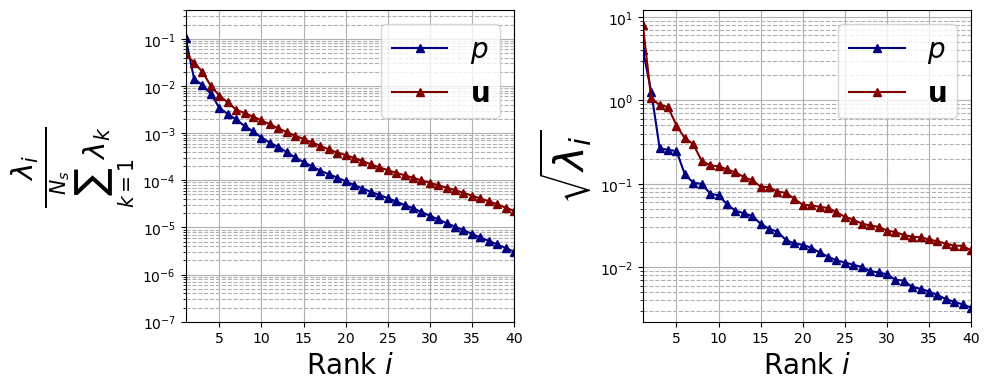

In [5]:
PODeigFig = plt.figure( figsize= (10,4))

plt.subplot(1,2,1)
color = iter(cm.jet(np.linspace(0, 1, len(var_names))))
for field_i in range(len(var_names)):
    c = next(color)
    plt.semilogy(np.arange(1,pod_data[field_i].eigenvalues.size+1,1),
                 1 - np.cumsum(pod_data[field_i].eigenvalues)/sum(pod_data[field_i].eigenvalues), "-^", c=c, label = "$" +tex_var_names[field_i]+"$", linewidth=1.5)   
plt.xlabel(r"Rank $i$",fontsize=20)
plt.xticks(np.arange(0,40+1,5))
plt.xlim(1,40)
plt.ylim(1e-7, .4)
plt.ylabel(r"$\frac{\lambda_i}{\sum_{k=1}^{N_s} \lambda_k}$",fontsize=30)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize=20)

plt.subplot(1,2,2)
color = iter(cm.jet(np.linspace(0, 1, len(var_names))))
for field_i in range(len(var_names)):
    c = next(color)
    plt.semilogy(np.arange(1,pod_data[field_i].eigenvalues[:40].size+1,1),
                 np.sqrt(pod_data[field_i].eigenvalues[:40]), "-^", c=c, label = "$" +tex_var_names[field_i]+"$", linewidth=1.5)   
plt.xlabel(r"Rank $i$",fontsize=20)
plt.xticks(np.arange(0,40+1,5))
plt.xlim(1,40)
plt.ylabel(r"$\sqrt{\lambda_i}$",fontsize=30)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize=20)

plt.tight_layout()

### Definition of the modes
Let us define and save the POD modes.

In [6]:
Nmax = 30

for ii in range(len(var_names)):
    pod_data[ii].compute_basis(train_snaps[ii], Nmax, normalise = True)

if not os.path.exists(path+'/BasisFunctions'):
    os.makedirs(path+'/BasisFunctions')

for ii in range(len(var_names)):
    store(domain, pod_data[ii].PODmodes, 'POD_' +var_names[ii], path+'/BasisFunctions/basisPOD_' + var_names[ii])

### Computing the training error
Then, let us compute the training errors and the POD basis coefficients. 

In [7]:
train_PODcoeff = []

idx_algo = 0
train_abs_err = np.zeros((Nmax, len(var_names)))
train_rel_err = np.zeros((Nmax, len(var_names)))

for ii in range(len(var_names)):
    tmp = pod_data[ii].train_error(train_snaps[ii], Nmax, verbose = True)

    train_abs_err[:, ii] = tmp[0].flatten()
    train_rel_err[:, ii] = tmp[1].flatten()
    
    train_PODcoeff.append(tmp[2])

Computing train error p: 120.000 / 120.00 - 0.042 s/it
Computing train error u: 120.000 / 120.00 - 0.055 s/it


The max absolute and relative reconstruction error is compared for the different algorithms, given the following definitions
\begin{equation*}
\begin{split}
E_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\\
\varepsilon_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}
\end{split}
\end{equation*}
given $\mathcal{P}_N[u]$ the reconstruction operator with $N$ basis functions.

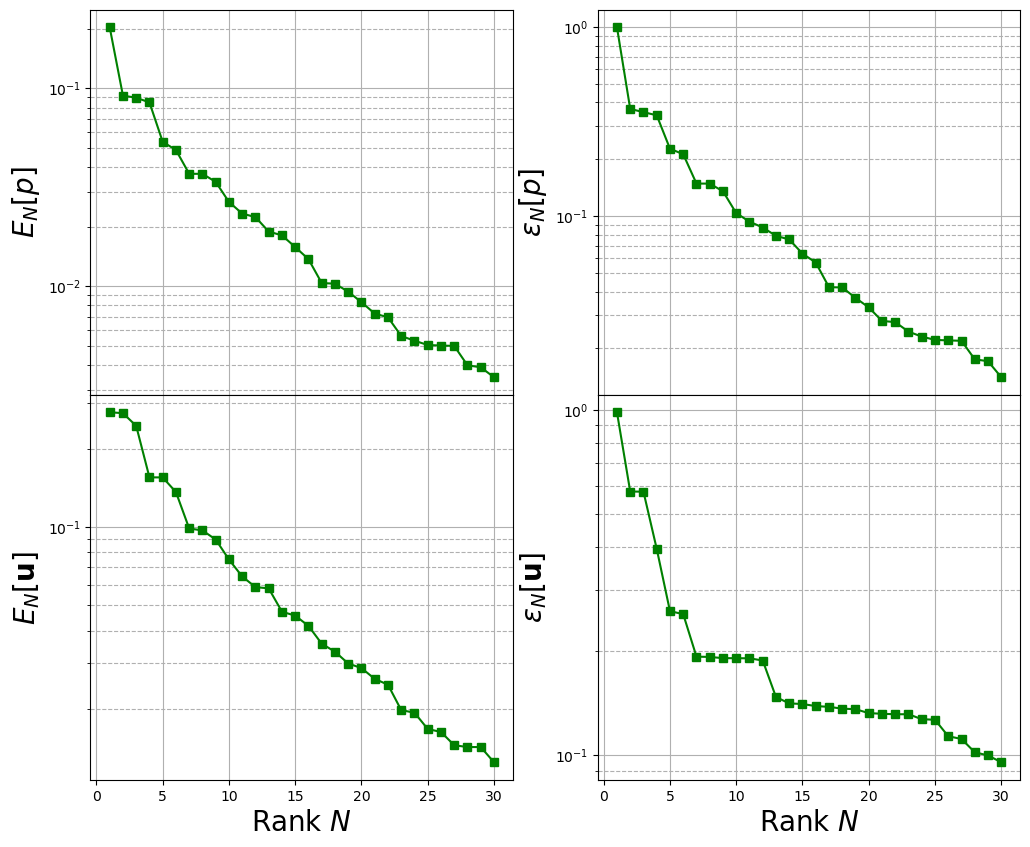

In [9]:
TrainingErrFig, axs = plt.subplots(nrows = len(var_names), ncols = 2, sharex = True, figsize = (12,10) )

Nmax = 30
M = np.arange(1,Nmax+1,1)

for ii in range(len(var_names)):
    
    axs[ii, 0].semilogy(M, train_abs_err[:Nmax, ii], 'g-s',   label = r'POD')
    axs[ii, 1].semilogy(M, train_rel_err[:Nmax, ii], 'g-s',   label = r'POD')

    axs[ii, 0].set_ylabel(r"$E_N["+tex_var_names[ii]+"]$",fontsize=20)
    axs[ii, 1].set_ylabel(r"$\varepsilon_N["+tex_var_names[ii]+"]$",fontsize=20)
    
axs[1, 0].set_xlabel(r"Rank $N$",fontsize=20)
axs[1, 1].set_xlabel(r"Rank $N$",fontsize=20)
    
for ax in axs.flatten():
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')   

TrainingErrFig.subplots_adjust(hspace = 0)

## Generation of the maps

In this section the maps between the parameters $\boldsymbol{\mu}$ and the POD coefficients $\alpha_m$, associated to the POD mode $\psi_m$, are generated through the following methods:

- Linear Interpolation
- Radial Basis Function Interpolation

Since the snapshots are randomly sampled, it is better to sort them (required by some interpolation methods).

In [30]:
train_pod_coeff = list()
coeff_maps = list()

for field_i in range(len(var_names)):
    idx_sorting = np.argsort(train_params[field_i])
    train_pod_coeff.append({'X': np.take(train_params[field_i], idx_sorting),
                            'Y': train_PODcoeff[field_i][idx_sorting]})
    
    coeff_maps.append(dict())

### Linear Interpolation
Given the training data, the map $t\longrightarrow \alpha_m(t)$ is built through piecewise linear interpolation.

In [70]:
from scipy.interpolate import interp1d

for field_i in range(len(var_names)):
        coeff_maps[field_i]['LinInt'] = [interp1d(train_pod_coeff[field_i]['X'].flatten(), 
                                        train_pod_coeff[field_i]['Y'][:, rank].flatten(),
                                        kind = 'cubic', fill_value = 'extrapolate')
                                        for rank in range(Nmax)]

### Radial Basis Function Interpolation
Given the training data, the map $t\longrightarrow \alpha_m(t)$ is built through Radial Basis Function interpolation.

In [71]:
from scipy.interpolate import RBFInterpolator

for field_i in range(len(var_names)):
        coeff_maps[field_i]['RBF'] = [RBFInterpolator( train_pod_coeff[field_i]['X'].reshape(-1,1),
                                                       train_pod_coeff[field_i]['Y'][:, rank].reshape(-1,1))
                                      for rank in range(Nmax)]

### Plotting the maps
For each field, the maps of the coefficients are plotted.

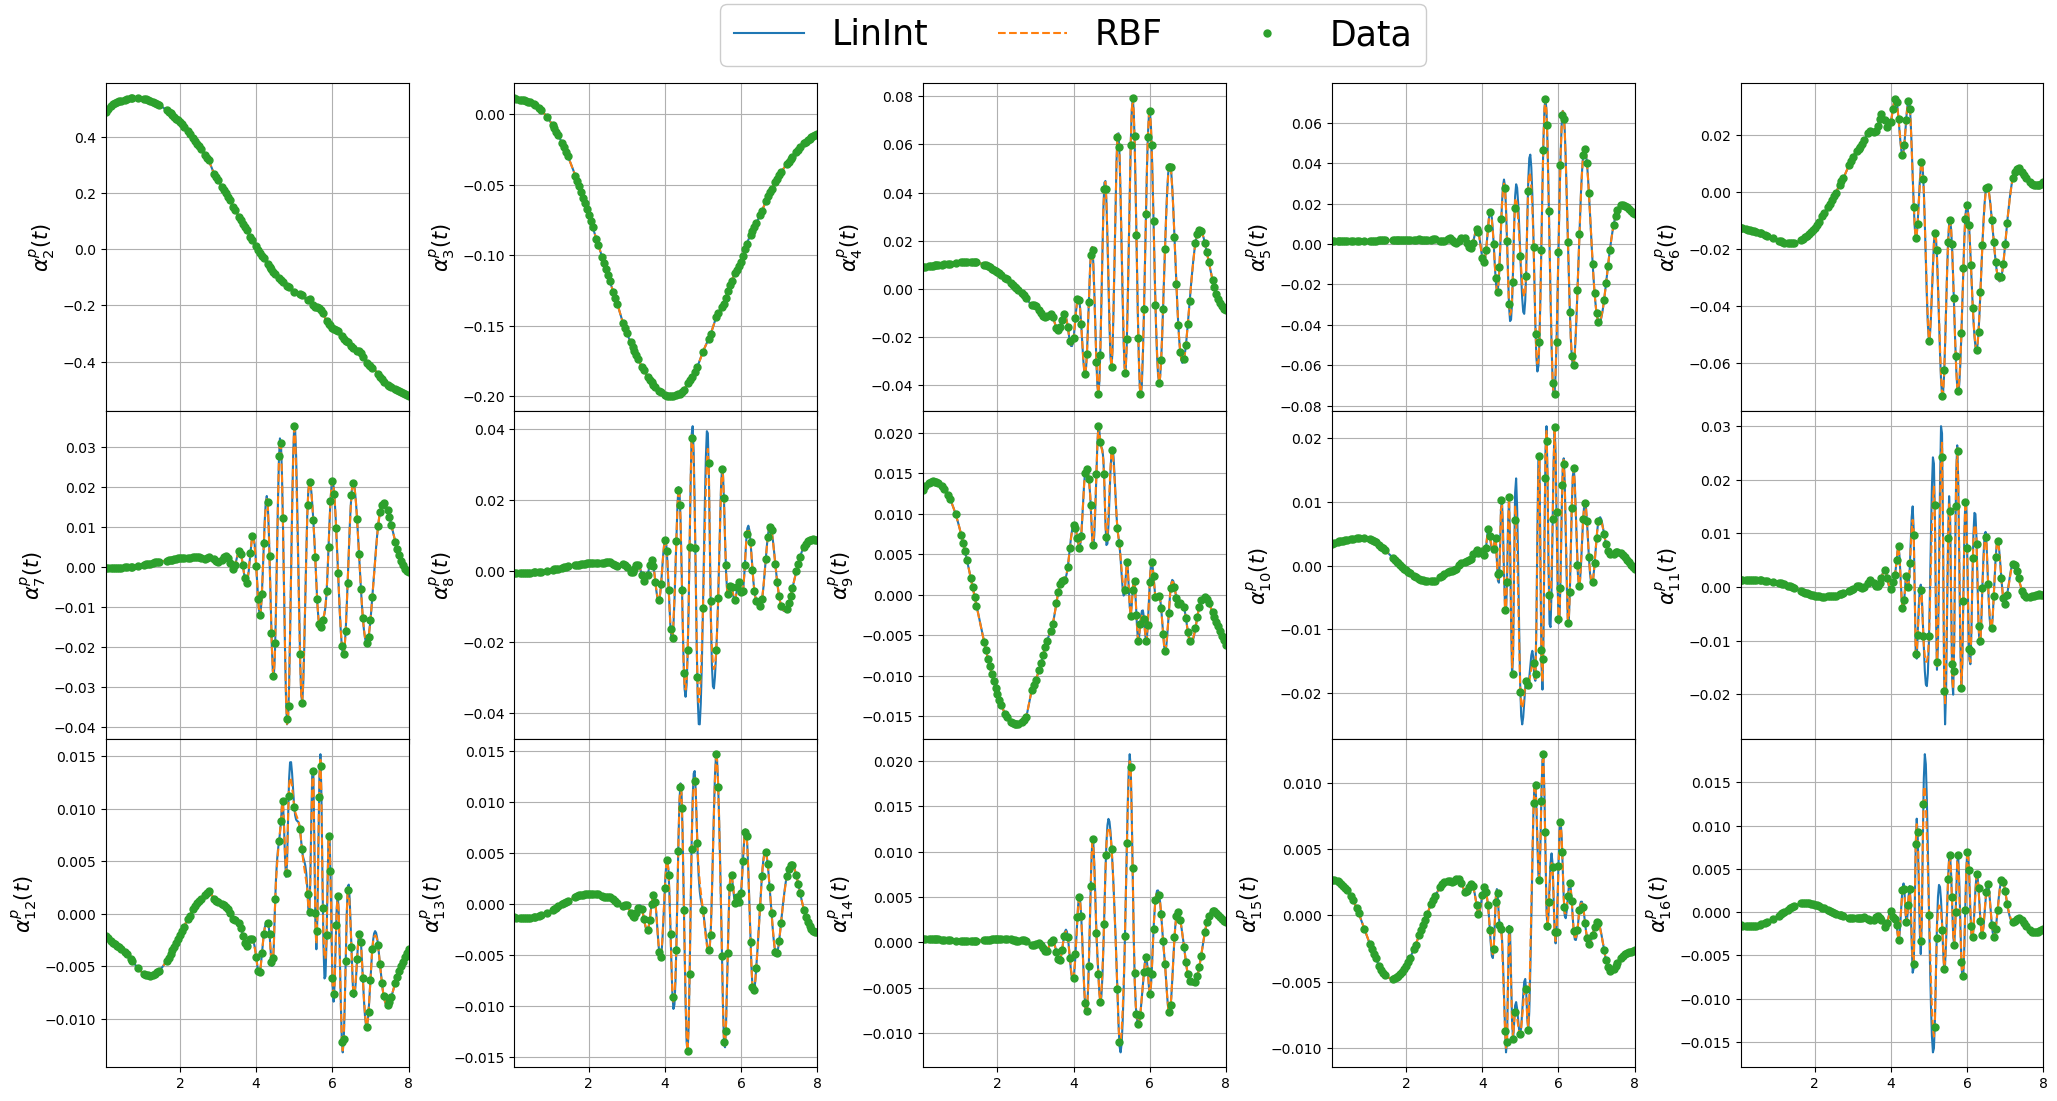

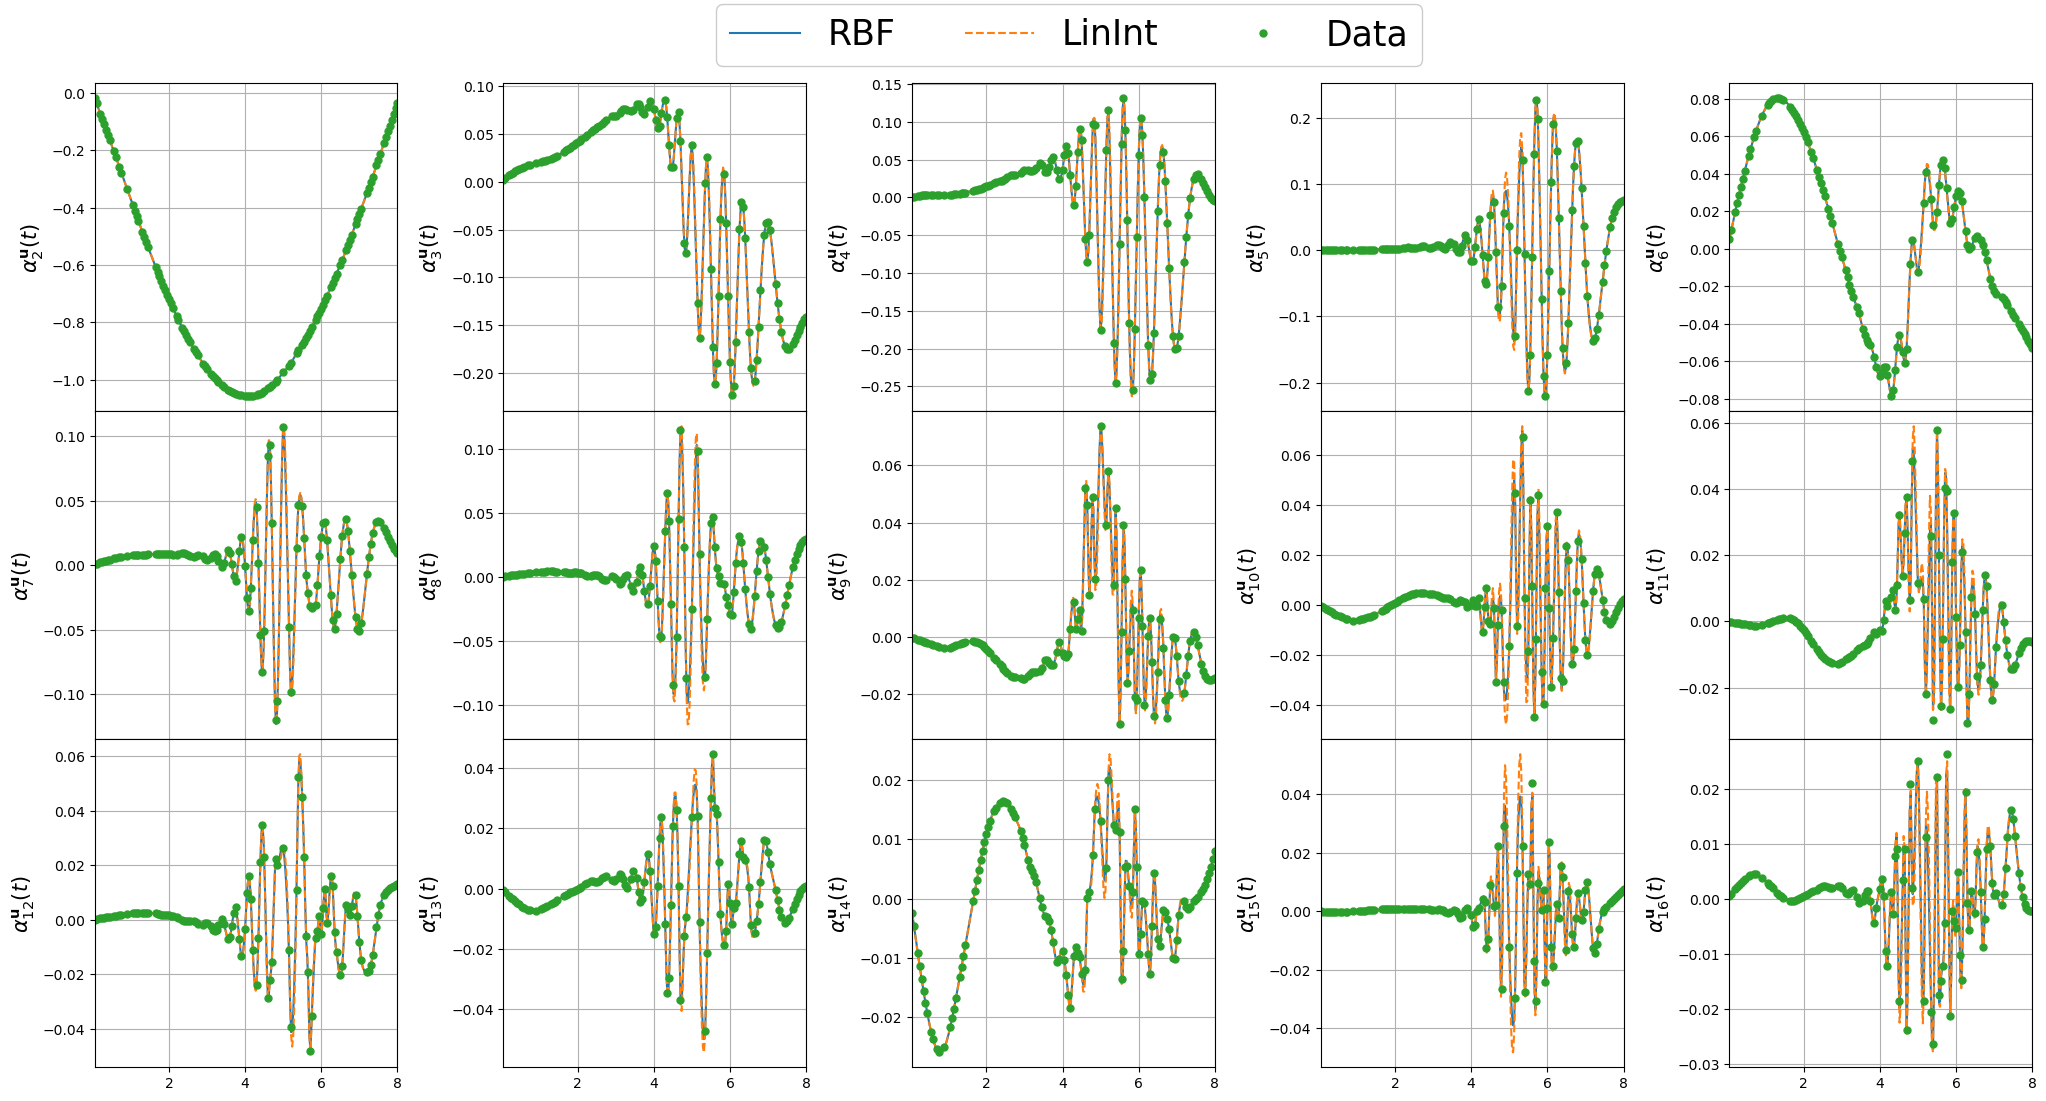

In [73]:
linestyles = ['-', '--', '-.', ':']

nrows = 3
ncols = 5

_x = np.linspace(min(train_pod_coeff[field_i]['X']), max(train_pod_coeff[field_i]['X']), 300)

for field_i in range(len(var_names)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharex=True)

    rank = 0
    for row in range(nrows):
        for col in range(ncols):
            for key_i, key in enumerate(list(coeff_maps[field_i].keys())):
                axs[row, col].plot(_x, coeff_maps[field_i][key][rank](_x.reshape(-1,1)), linestyles[key_i], label = key)
            
            axs[row, col].plot(train_pod_coeff[field_i]['X'], train_pod_coeff[field_i]['Y'][:, rank], 'o', markersize=5, label = 'Data')
            rank += 1
            
            axs[row, col].grid()
            axs[row, col].set_xlim(min(_x), max(_x))
            axs[row, col].set_ylabel(r'$\alpha_{'+str(rank+1)+'}^'+tex_var_names[field_i]+'(t)$', fontsize=15)
            
            
    Line, Label = axs[0,0].get_legend_handles_labels()    
    fig.legend(Line, Label, framealpha = 1, fontsize=25, loc=(0.35, 0.94), ncols=3)

    fig.subplots_adjust(hspace=0, wspace=0.35, top = 0.93)
    plt.show()

Let us store the maps using *pickle*

In [76]:
import pickle

pickle.dump(coeff_maps, open(path+'/pod_coeff.maps', 'wb'))
pickle.dump(train_pod_coeff, open(path+'/train_pod_coeff.sorted', 'wb'))

## Post Process: plotting the POD modes
In this last section, *pyvista* is used to make some contour plots of the POD modes for both pressure and velocity.

In [35]:
import vtk
import pyvista as pv
import dolfinx

pv.start_xvfb()

def vector_grids(fun: dolfinx.fem.Function, mag_plot: bool, varname='u'):
    
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    grid = pv.UnstructuredGrid(topology, cells, geometry)

    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(fun)] = np.real(fun.x.array.reshape(geometry.shape[0], len(fun)))
    grid[varname] = values

    if mag_plot:
        warped = grid.warp_by_vector(varname, factor=0.0) 
    else:
        warped = grid.glyph(varname, factor=0.06, tolerance=0.0125)
        
    return warped, values

def grids(fun: dolfinx.fem.Function):
    topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    u_grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    u_grid.point_data['fun'] = fun.x.array[:].real
    u_grid.set_active_scalars('fun')
    return u_grid

def plotModes( pod_modes: FunctionsList, varname: str, shape : list,
               mag_plot = True, colormap = cm.jet):  
    
    nrows = shape[0]
    ncols = shape[1]
    
    resolution = [900 * ncols, 400 * nrows]
    plotter = pv.Plotter(shape=shape, off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 25
    title_fontsize = 35
    zoom = 2.25
    
    dict_cb = dict(title = varname, width = 0.75, height = 0.2,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    n_labels=3,
                    color = 'k',
                    position_x=0.125, position_y=0.745,
                    shadow=False) 
    
    if pod_modes.fun_space.num_sub_spaces > 0:
        vector_plot = True
    else:
        vector_plot = False
    
    idx = 0
    for row in range(nrows):
        for col in range(ncols):
            if vector_plot:
                warped, values = vector_grids(pod_modes.map(idx), mag_plot, varname=varname)
                clim = [0., max(np.sqrt(values[:, 0]**2+values[:, 1]**2+values[:, 2]**2))]
            else:
                warped = grids(pod_modes.map(idx))
                clim = [min(pod_modes(idx)), max(pod_modes(idx))]
                
            plotter.subplot(row, col)
            dict_cb['title'] = '$'+varname+'$'+' - POD mode '+str(idx+1)
            plotter.add_mesh(warped, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
            plotter.view_xy()
            plotter.camera.zoom(zoom)
            
            idx += 1

    plotter.set_background('white', top='white')
    plotter.show()

Let us plot the first 10 POD modes of each variable.

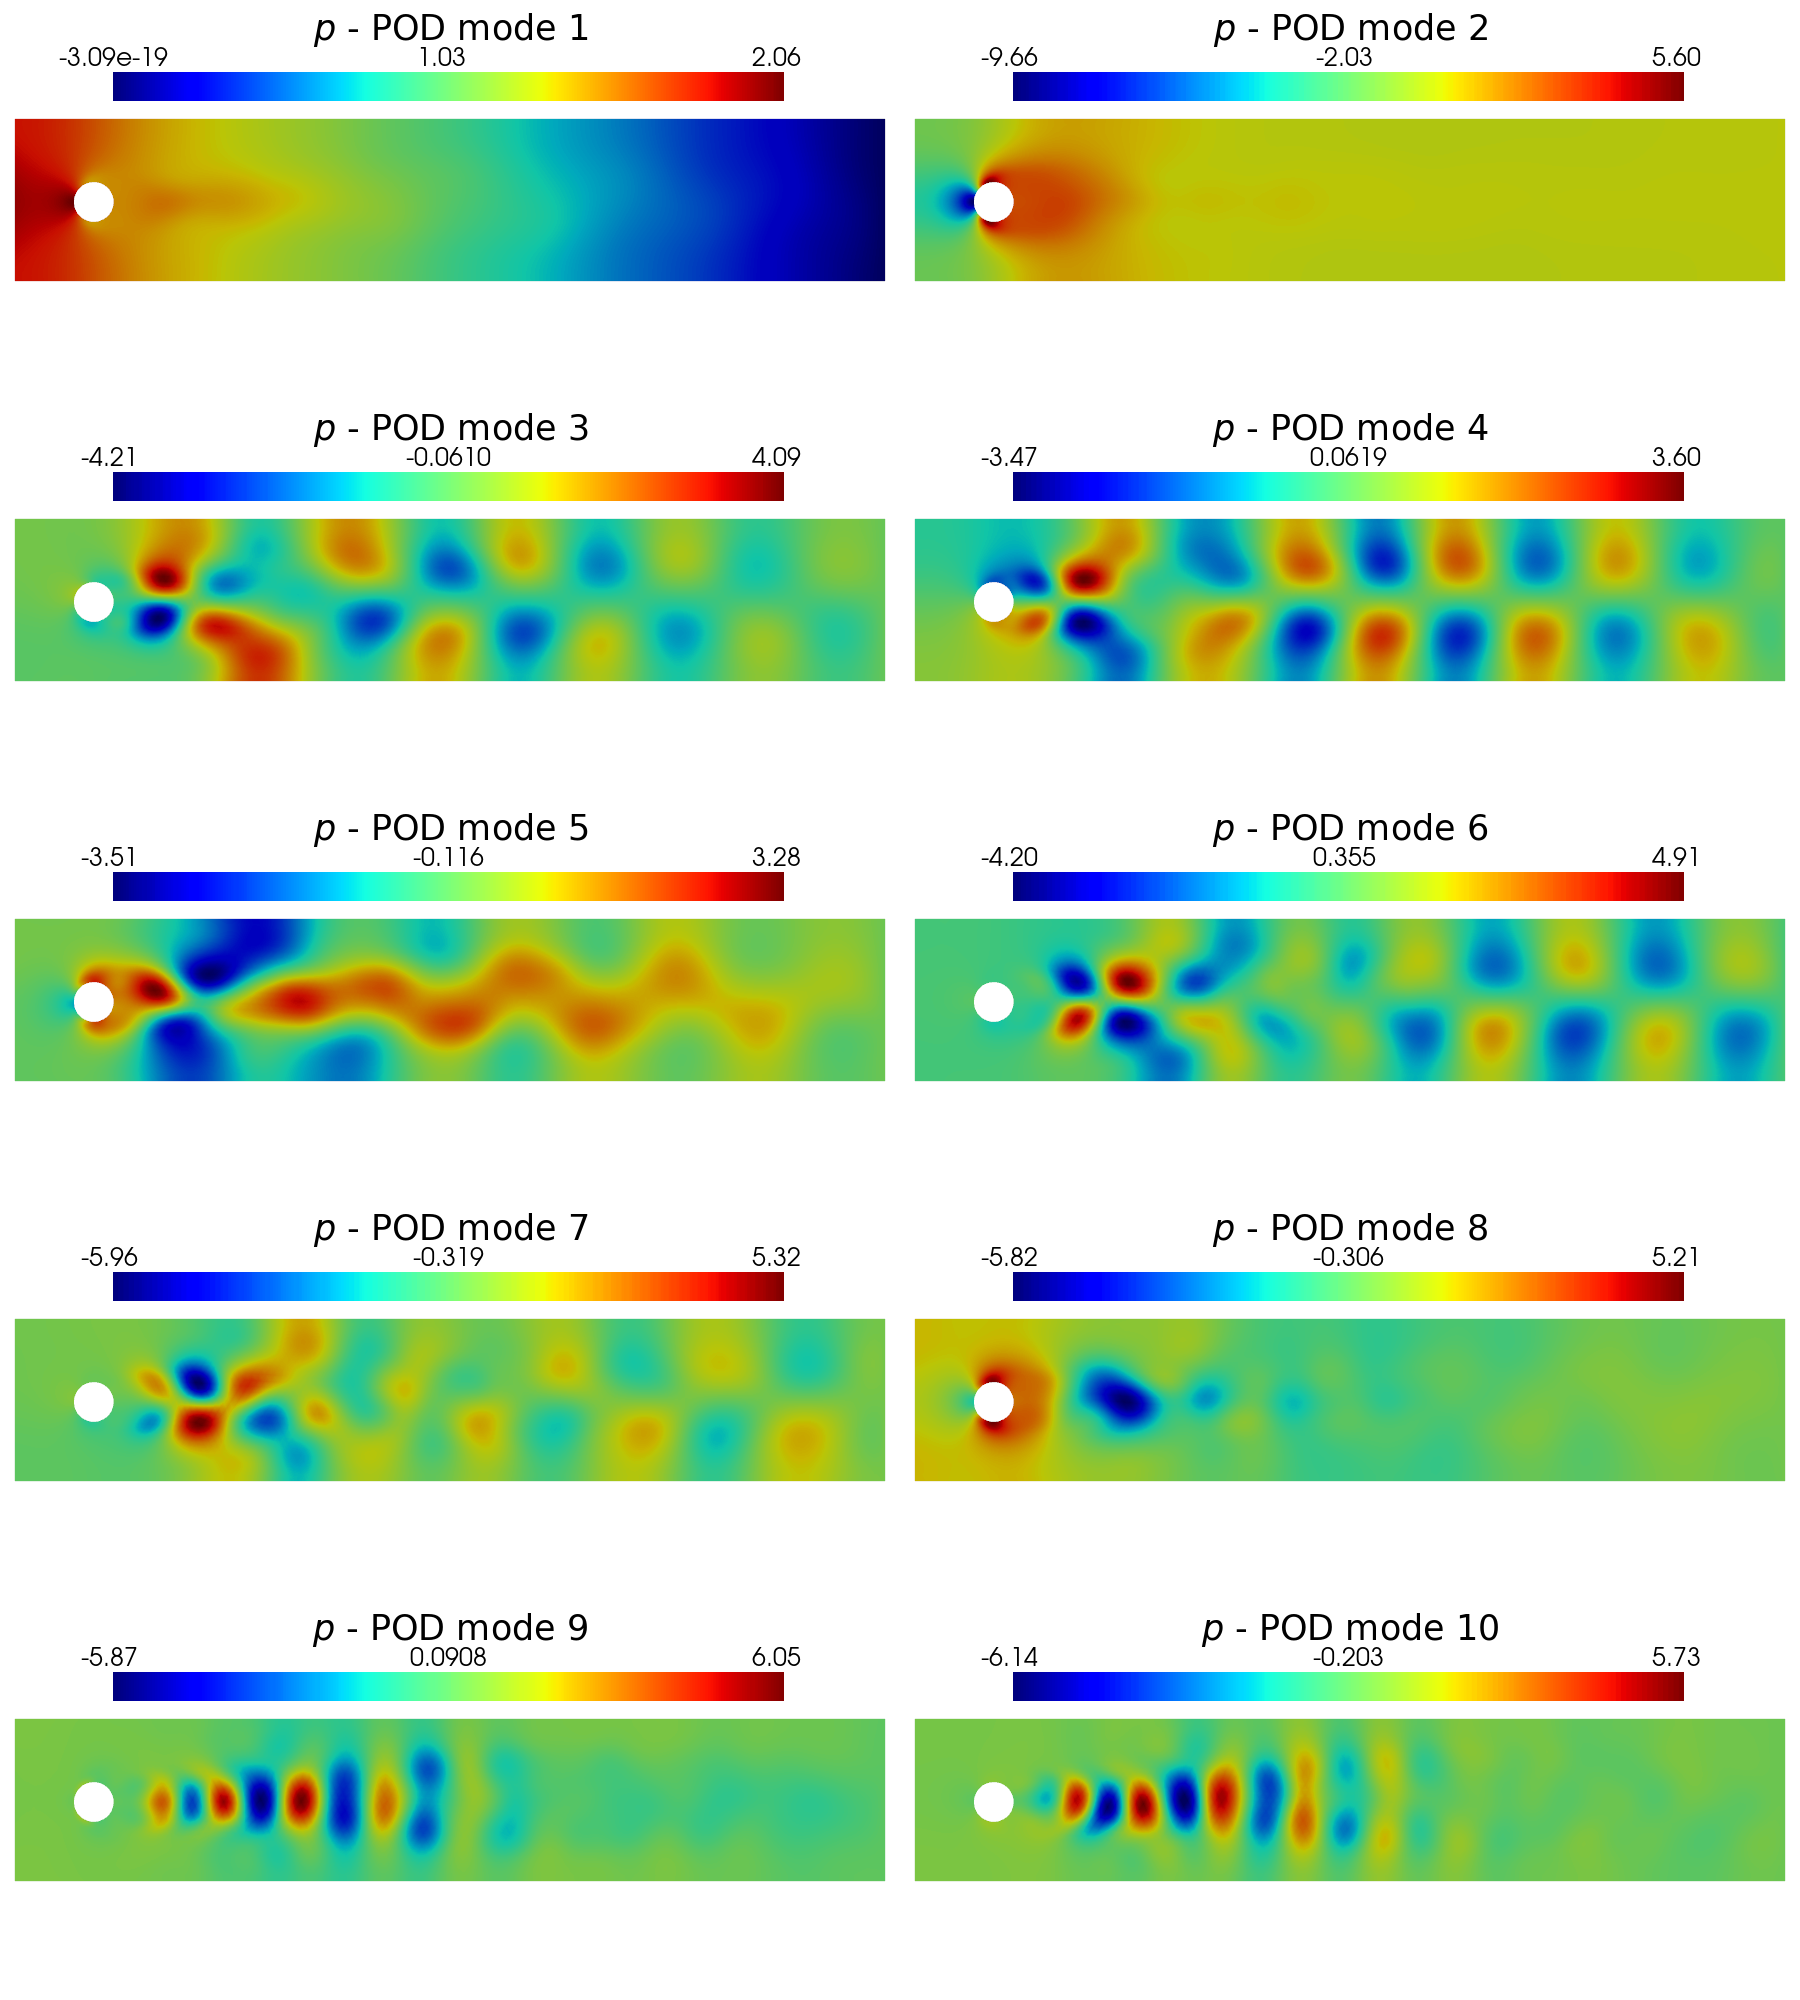

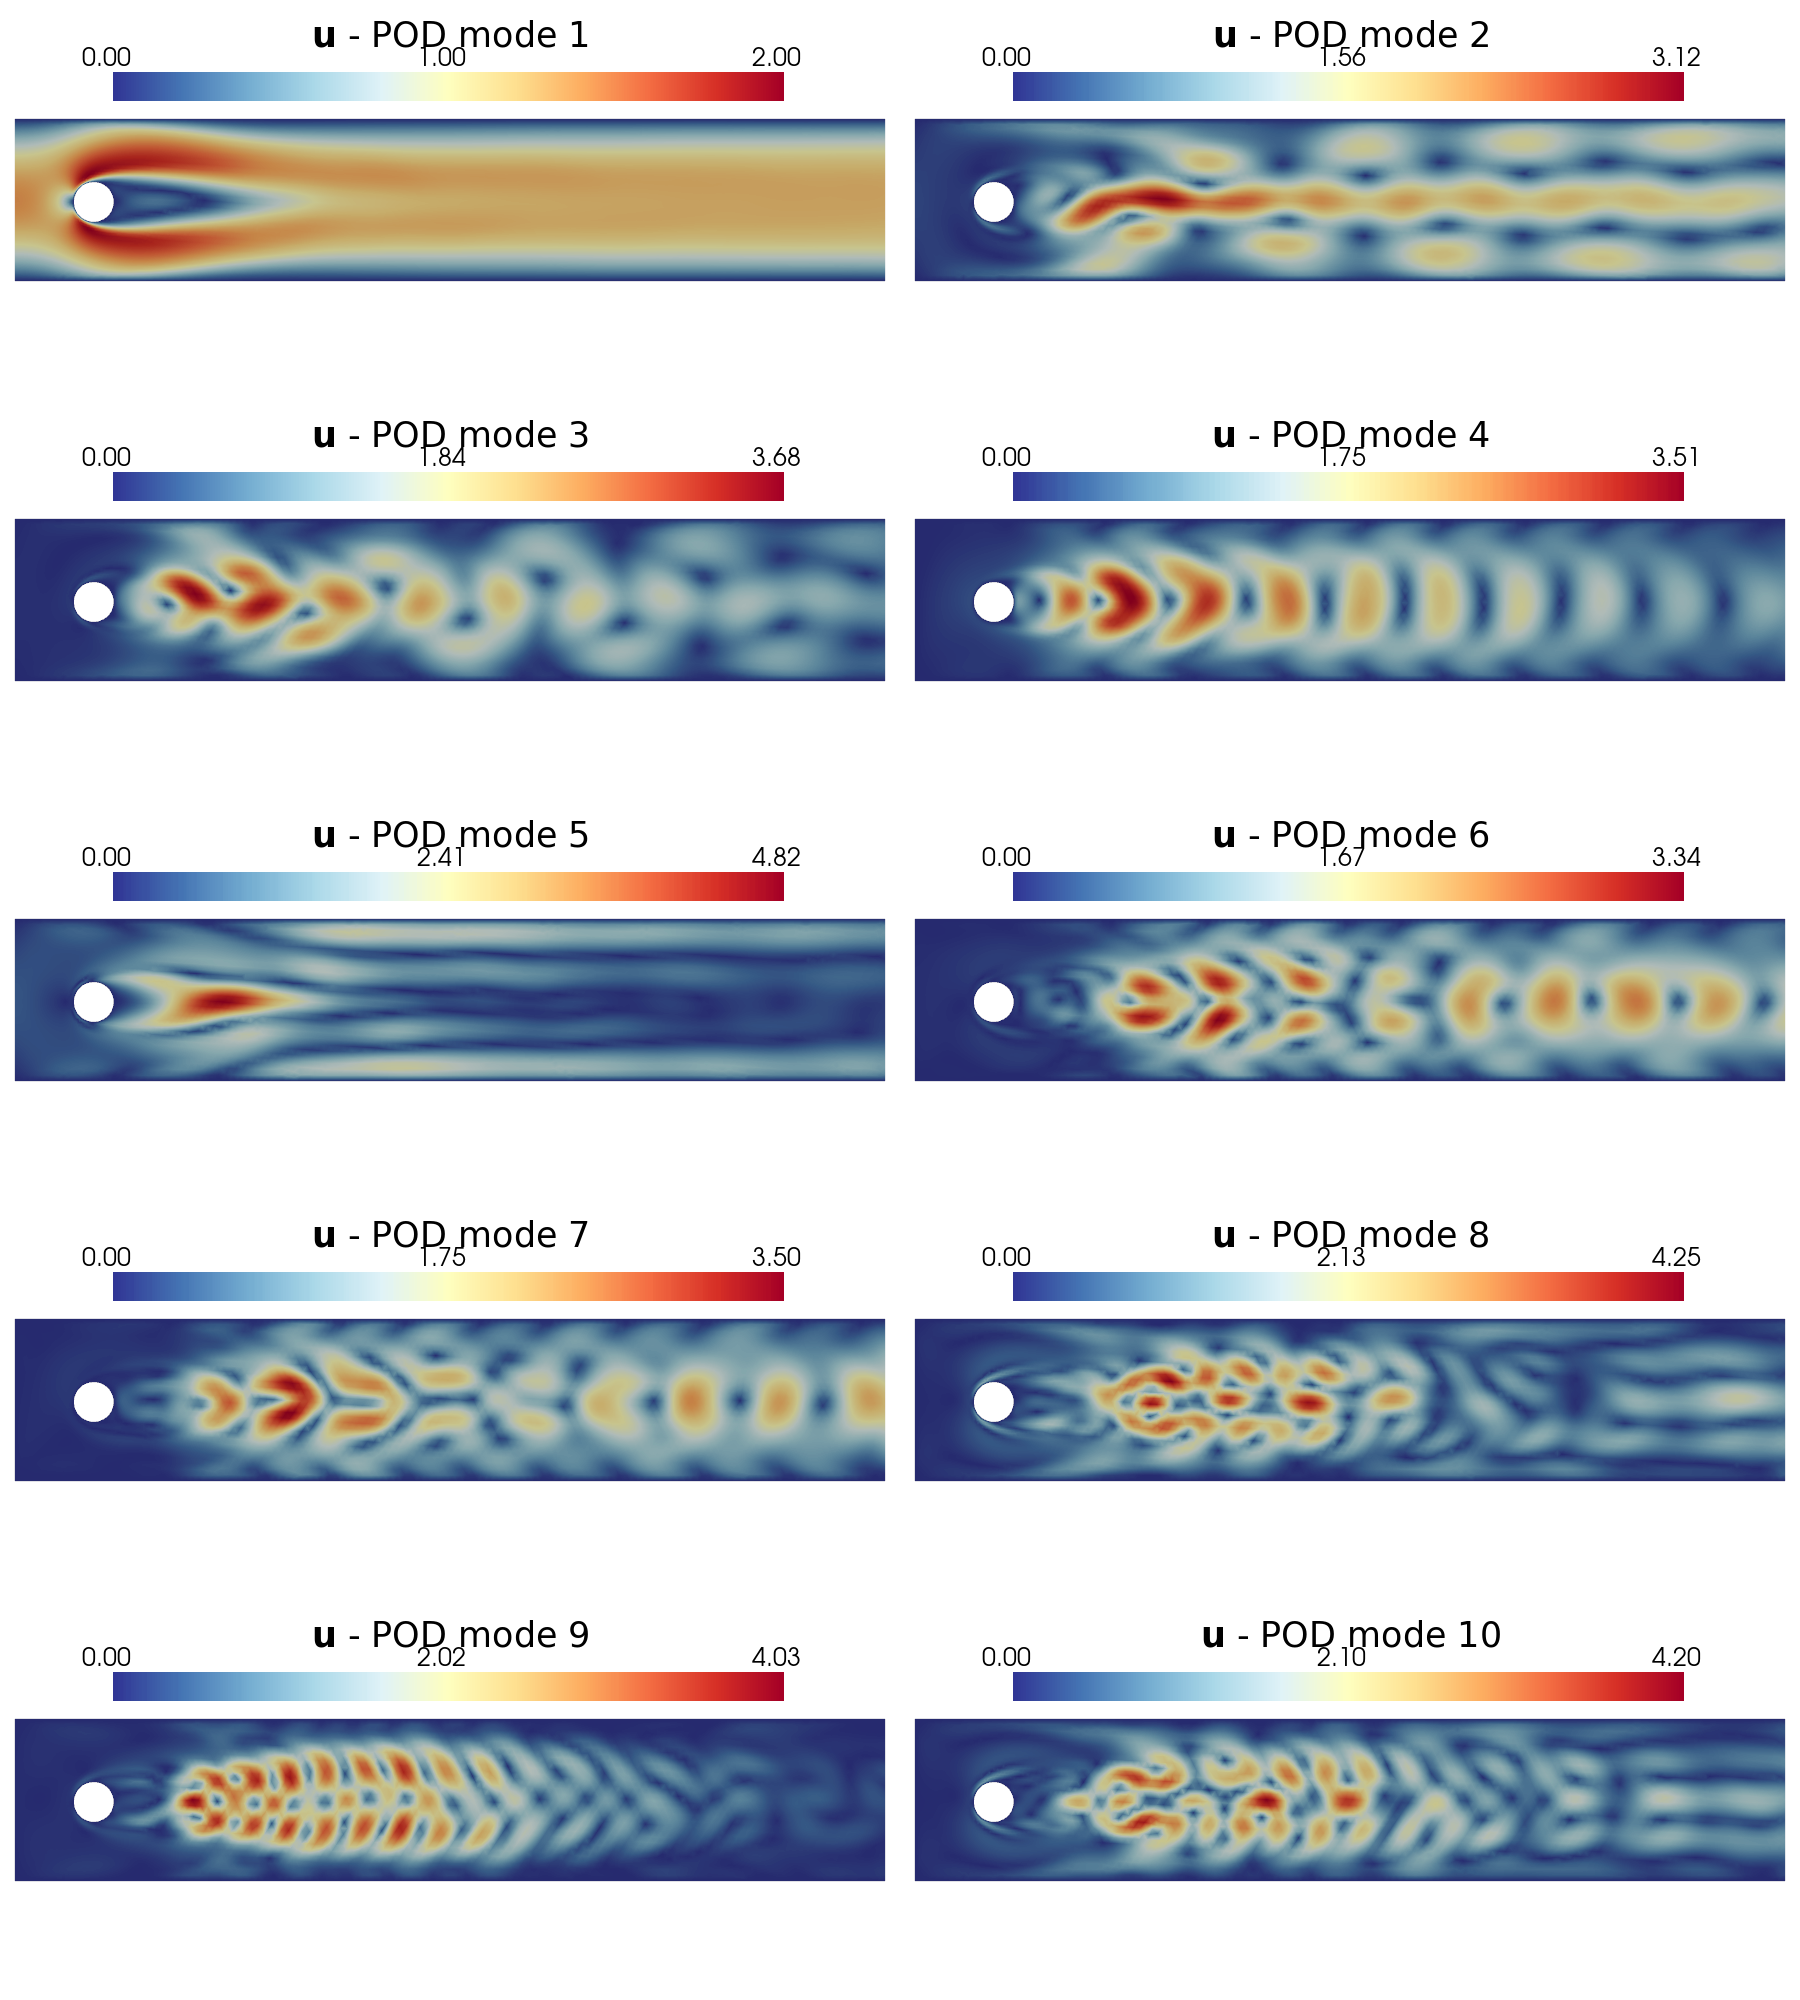

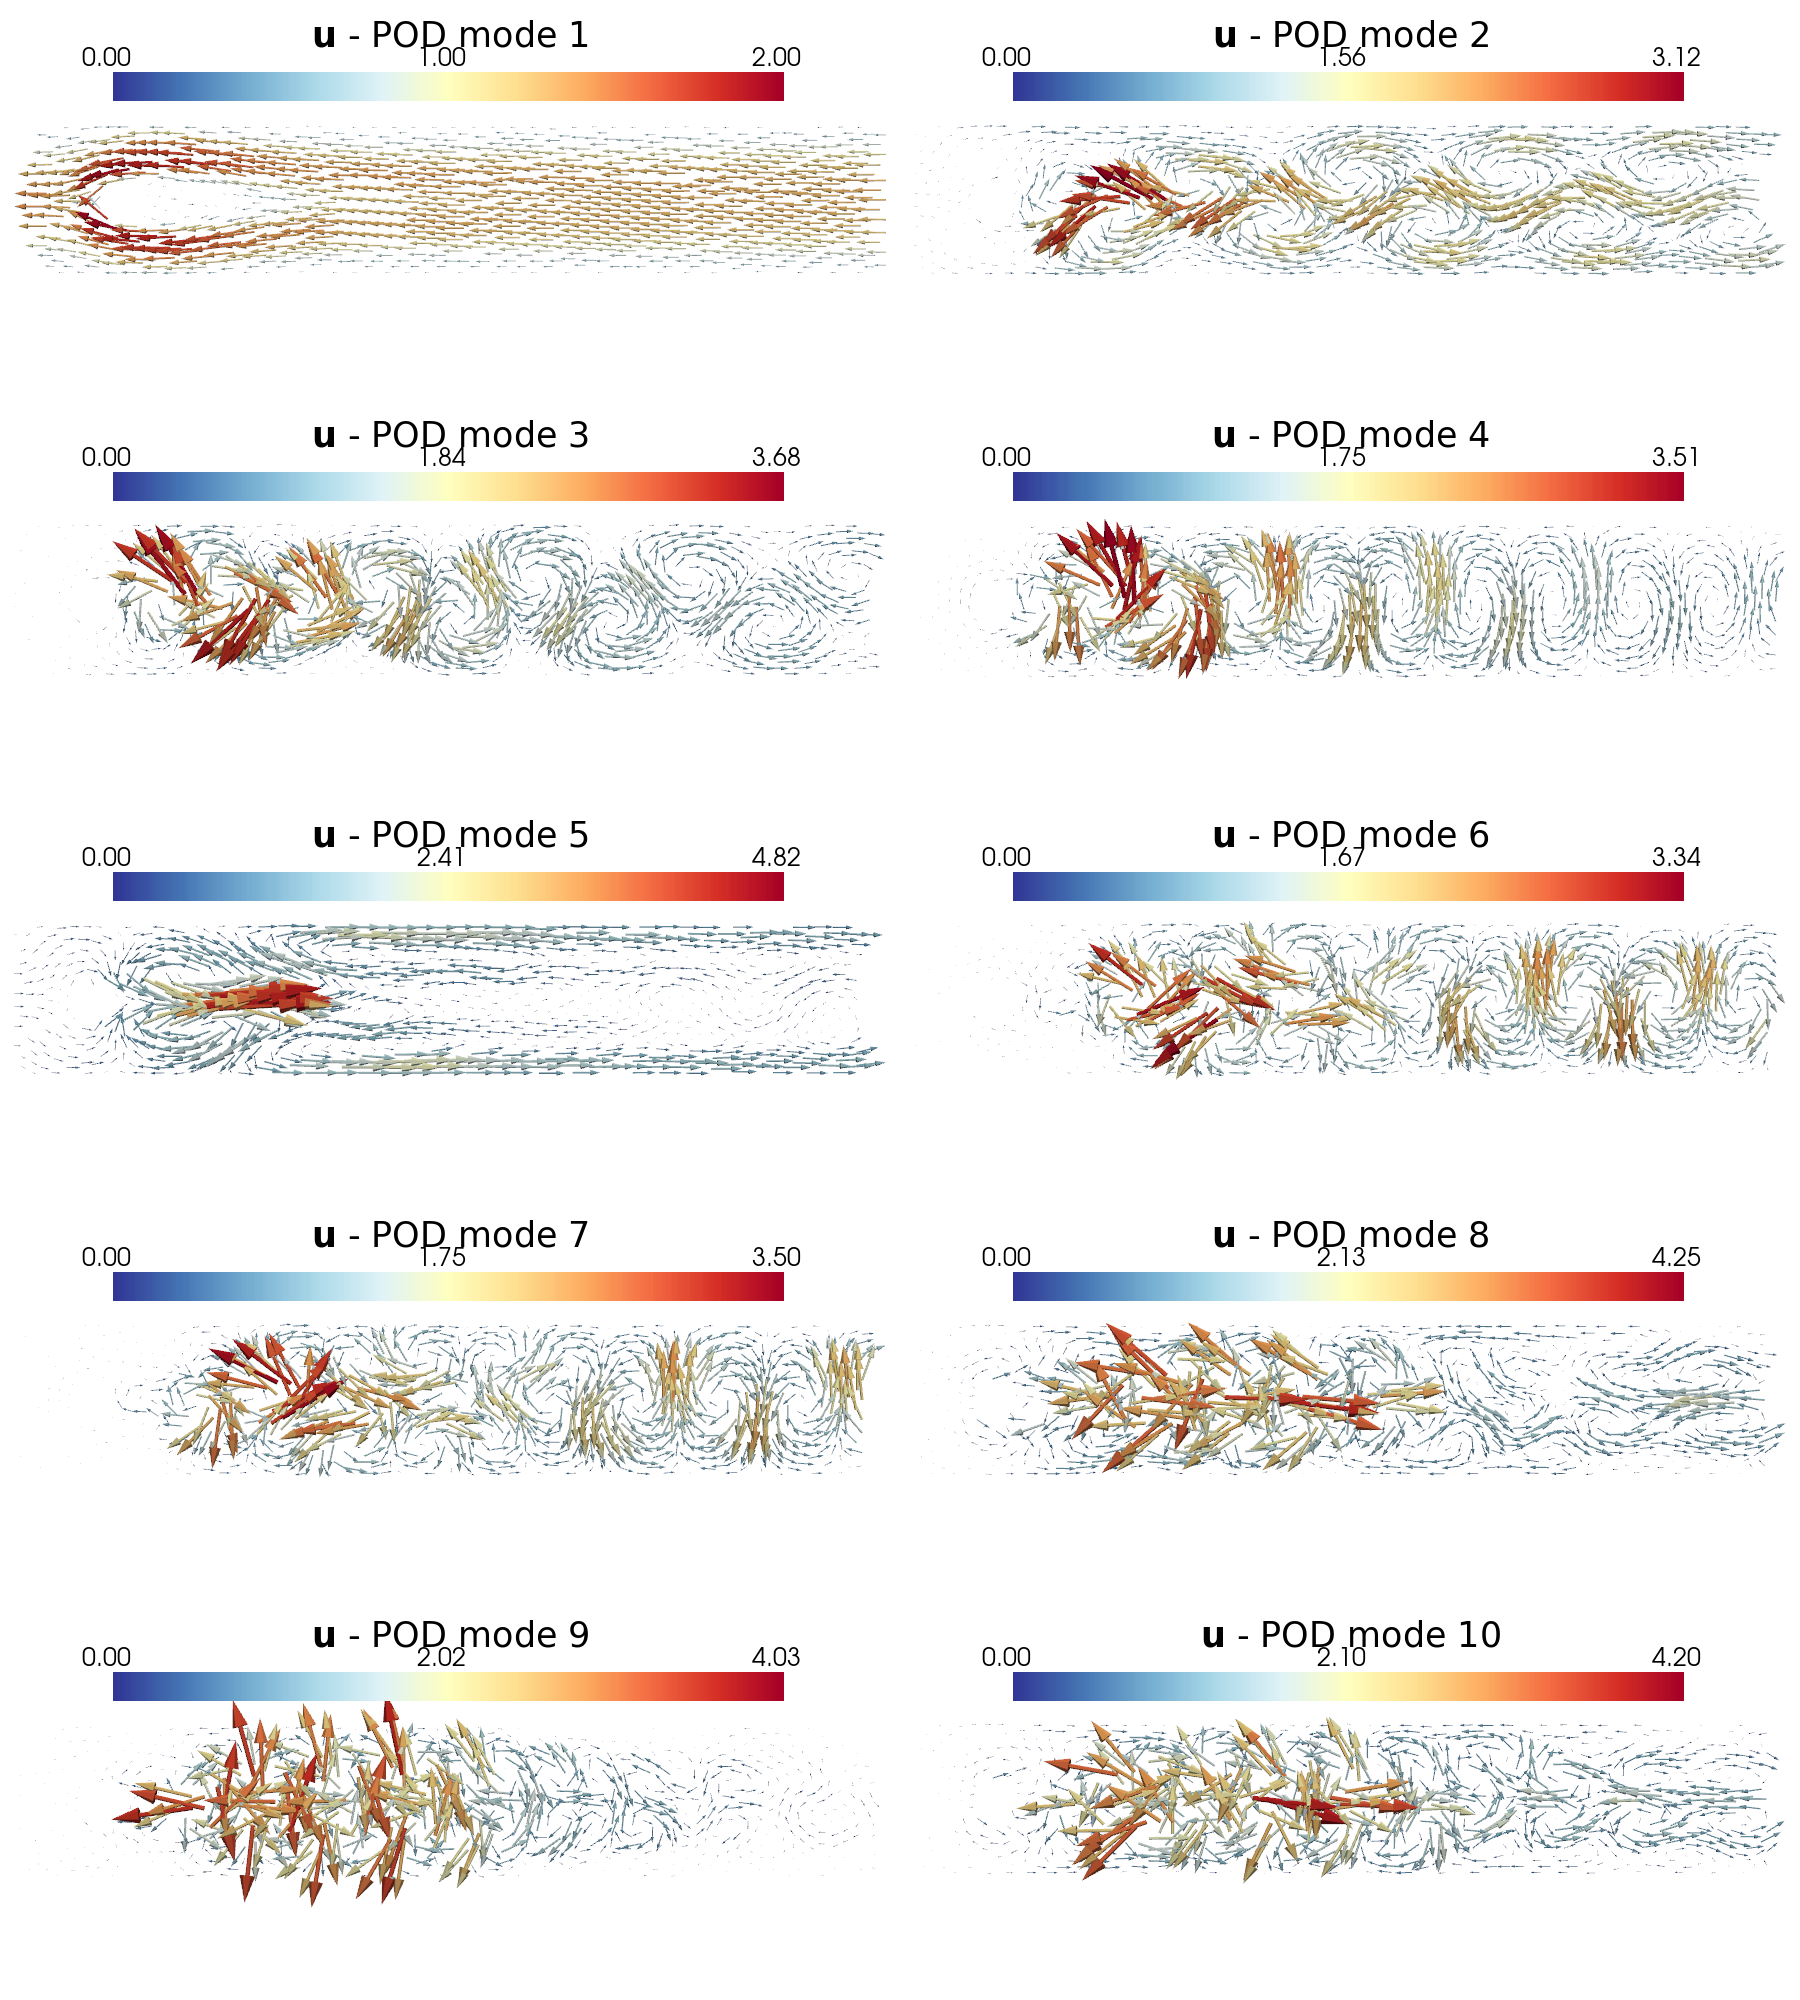

In [36]:
plotModes(pod_data[0].PODmodes, tex_var_names[0], shape = [5,2], colormap=cm.jet)
plotModes(pod_data[1].PODmodes, tex_var_names[1], shape = [5,2], colormap=cm.RdYlBu_r)
plotModes(pod_data[1].PODmodes, tex_var_names[1], shape = [5,2], mag_plot = False, colormap=cm.RdYlBu_r)